In [212]:
# import imagery
path = "/Users/dk/Documents.nosync/msc-project/blender/gen_datasets/datasets/cuerpo_sequence1/data/"

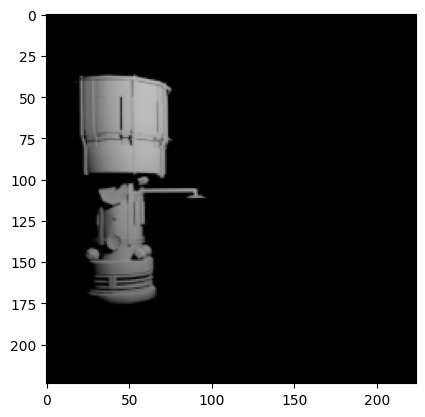

In [213]:

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.open(path + "real_1.png").convert('RGB')
img_np = np.array(img)/255.0
plt.imshow(img_np);


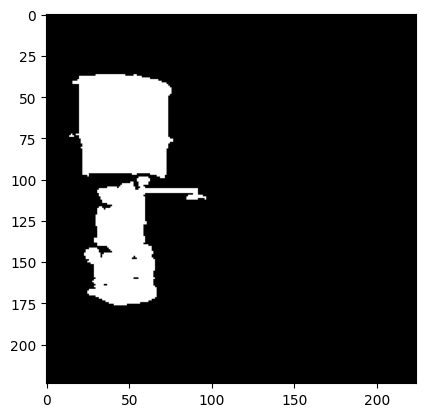

In [214]:
img_np_copy = img_np.copy()
img_np_copy[np.where(img_np_copy<0.01)] = 0
img_np_copy[np.where(img_np_copy>0.01)] = 1
plt.imshow(img_np_copy);

In [215]:
y,x,c = np.where(img_np_copy>0)
ymin, ymax = np.min(y), np.max(y)
xmin, xmax = np.min(x), np.max(x)
height = ymax - ymin
width = xmax - xmin
print(ymin, ymax, xmin, xmax)
print(height, width)

37 176 14 96
139 82


In [216]:

def model_dimensions(img_np:np.ndarray):
    # assert img.min() == 0 and img.max() == 1

    # create object mask
    img_np_copy = img_np.copy()
    img_np_copy[np.where(img_np_copy<0.01)] = 0
    img_np_copy[np.where(img_np_copy>0.01)] = 1

    # determine object dimensions
    y,x,c = np.where(img_np_copy>0)
    ymin, ymax = np.min(y), np.max(y)
    xmin, xmax = np.min(x), np.max(x)
    height = ymax - ymin
    width = xmax - xmin
    return height, width, ymin, ymax, xmin, xmax


In [217]:
import os
import glob
import re

path = "/Users/dk/Documents.nosync/msc-project/blender/gen_datasets/datasets/cuerpo_sequence1/data/"
png_files = glob.glob(os.path.join(path, '*.png'))
json_files = glob.glob(os.path.join(path, '*.json'))


def extract_png_number(filename):
    match = re.search(r'(\d+).png$', filename)
    if match:   return int(match.group(1))
    else:       return -1
    
def extract_json_number(filename):
    match = re.search(r'(\d+).json$', filename)
    if match:   return int(match.group(1))
    else:       return -1

png_files.sort(key=extract_png_number)
json_files.sort(key=extract_json_number)


In [218]:
# extract translation (yvals) from the data

import json

translations = []
for json_f in json_files:
    with open(json_f) as f: translations.append(json.load(f)['translation'])

translations = np.array(translations, dtype=np.float32)
y_vals = translations


# extract dimensions (xvals) from the data

dimensions = []
for png_f in png_files:
    img = Image.open(png_f).convert('RGB')
    img_np = np.array(img)/255.0
    dimensions.append(model_dimensions(img_np))
dimensions = np.array(dimensions, dtype=np.float32)
xvals = dimensions


In [219]:
# train a linear regression model

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(xvals, y_vals)
print(reg.score(xvals, y_vals)) # R^2 score

# predict model on xvals
y_pred = reg.predict(xvals)

# predict mse
import sklearn
sklearn.metrics.mean_squared_error(y_vals, y_pred, squared=False)

0.9965363486866545


0.07229332

In [222]:
# pose estimation quaternion flip (for the neural nets)

In [60]:
import itertools

# Generate all possible combinations of True and False for 4 variables
variable_values = [True, False]
combinations = list(itertools.product(variable_values, repeat=4))
combinations

[(True, True, True, True),
 (True, True, True, False),
 (True, True, False, True),
 (True, True, False, False),
 (True, False, True, True),
 (True, False, True, False),
 (True, False, False, True),
 (True, False, False, False),
 (False, True, True, True),
 (False, True, True, False),
 (False, True, False, True),
 (False, True, False, False),
 (False, False, True, True),
 (False, False, True, False),
 (False, False, False, True),
 (False, False, False, False)]

In [67]:
batch_size = 16
a = np.random.rand(batch_size, 4) - 0.5
a

array([[-0.16911537,  0.32210239,  0.31070777,  0.42321303],
       [-0.14541049,  0.4574783 , -0.00552036,  0.29097253],
       [-0.30999057,  0.47601562, -0.33101008, -0.4364266 ],
       [-0.34579714, -0.37257828,  0.32885824,  0.13977646],
       [-0.02027312, -0.29537878,  0.4850554 , -0.101315  ],
       [ 0.1461844 ,  0.09847735,  0.03907052,  0.29151492],
       [-0.30647548, -0.23880164, -0.18380765,  0.1158014 ],
       [-0.32699522, -0.24076205,  0.05884805,  0.1154209 ],
       [ 0.01525135,  0.31338872,  0.01478827, -0.41076527],
       [ 0.10381795, -0.15001509,  0.47650804,  0.07260548],
       [ 0.39726032,  0.03858539,  0.33912128,  0.32721122],
       [-0.15672651, -0.14043381, -0.36994071,  0.24864029],
       [-0.04210347,  0.06761007, -0.40110815,  0.156881  ],
       [ 0.43046192, -0.12948327, -0.33945941, -0.24109926],
       [ 0.16685169, -0.30935325, -0.05527981, -0.42656864],
       [ 0.49371993,  0.01061123, -0.42596852,  0.27756018]])

In [69]:
a_bools = a>0
a_bools

array([[False,  True,  True,  True],
       [False,  True, False,  True],
       [False,  True, False, False],
       [False, False,  True,  True],
       [False, False,  True, False],
       [ True,  True,  True,  True],
       [False, False, False,  True],
       [False, False,  True,  True],
       [ True,  True,  True, False],
       [ True, False,  True,  True],
       [ True,  True,  True,  True],
       [False, False, False,  True],
       [False,  True, False,  True],
       [ True, False, False, False],
       [ True, False, False, False],
       [ True,  True, False,  True]])

In [74]:
a[a_bools[:,0]==False]*=-1
a

array([[ 0.16911537, -0.32210239, -0.31070777, -0.42321303],
       [ 0.14541049, -0.4574783 ,  0.00552036, -0.29097253],
       [ 0.30999057, -0.47601562,  0.33101008,  0.4364266 ],
       [ 0.34579714,  0.37257828, -0.32885824, -0.13977646],
       [ 0.02027312,  0.29537878, -0.4850554 ,  0.101315  ],
       [ 0.1461844 ,  0.09847735,  0.03907052,  0.29151492],
       [ 0.30647548,  0.23880164,  0.18380765, -0.1158014 ],
       [ 0.32699522,  0.24076205, -0.05884805, -0.1154209 ],
       [ 0.01525135,  0.31338872,  0.01478827, -0.41076527],
       [ 0.10381795, -0.15001509,  0.47650804,  0.07260548],
       [ 0.39726032,  0.03858539,  0.33912128,  0.32721122],
       [ 0.15672651,  0.14043381,  0.36994071, -0.24864029],
       [ 0.04210347, -0.06761007,  0.40110815, -0.156881  ],
       [ 0.43046192, -0.12948327, -0.33945941, -0.24109926],
       [ 0.16685169, -0.30935325, -0.05527981, -0.42656864],
       [ 0.49371993,  0.01061123, -0.42596852,  0.27756018]])

In [83]:
# 

from skimage.feature import ORB
from skimage.color import rgb2gray

img = Image.open(path + "real_3.png").convert('RGB')
img_np = np.array(img)/255.0
img_gray = rgb2gray(img_np)
descriptor_extractor = ORB(n_keypoints=200)

descriptor_extractor.detect_and_extract(img_gray)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors





descriptors1.shape


(200, 256)

In [96]:
descriptors1

array([[ True,  True, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False,  True, ...,  True, False, False],
       ...,
       [ True, False,  True, ...,  True,  True, False],
       [False,  True, False, ...,  True,  True, False],
       [ True,  True, False, ..., False,  True,  True]])

In [223]:

### ORB xvals

x_vals_orb = []
descriptor_extractor = ORB(n_keypoints=200)

for png_f in png_files:
    img = Image.open(png_f).convert('RGB')
    img_np = np.array(img)/255.0
    img_gray = rgb2gray(img_np)
    descriptor_extractor.detect_and_extract(img_gray)
    x_vals_orb.append(descriptor_extractor.descriptors.astype(np.float32))

smallest_length = min([len(x) for x in x_vals_orb])
x_vals_orb = [x[:smallest_length] for x in x_vals_orb]
x_vals_orb = np.array(x_vals_orb, dtype=np.float32)
x_vals_orb = x_vals_orb.reshape(101, -1)


### yvals

y_vals_orb = []
for json_f in json_files:
    with open(json_f) as f: y_vals_orb.append(json.load(f)['pose'])

y_vals_orb = np.array(y_vals_orb, dtype=np.float32)
x_vals_orb.shape, y_vals_orb.shape


((101, 38656), (101, 4))

In [224]:

# train a linear regression model
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_vals_orb, y_vals_orb)
print(reg.score(x_vals_orb, y_vals_orb)) # R^2 score

# predict model on xvals
y_pred_orb = reg.predict(x_vals_orb)

# predict mse
import sklearn
print(sklearn.metrics.mean_squared_error(y_vals_orb, y_pred_orb, squared=False))


0.9999999999757851
4.6379915e-07


In [111]:
x_vals_orb.shape

(101, 38656)

In [114]:
reg.predict(x_vals_orb[0][np.newaxis,...]), y_vals_orb[0]

(array([[ 1.0000001e+00, -1.4901161e-07, -1.4901161e-07, -1.4901161e-07]],
       dtype=float32),
 array([1., 0., 0., 0.], dtype=float32))

In [120]:
####### MODEL ORB


def ORB_PREDICT(img:np.ndarray, model:LinearRegression):
    return model.predict(img)

ORB_PREDICT(x_vals_orb[0][np.newaxis,...], reg);


In [104]:

##### ON THE 10K DATASET?!?

import os
import glob
import re
from tqdm import tqdm
from skimage.feature import ORB
from skimage.color import rgb2gray
from PIL import Image
import numpy as np


path = "/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random_10k/data"
png_files = glob.glob(os.path.join(path, '*.png'))
json_files = glob.glob(os.path.join(path, '*.json'))

def extract_png_number(filename):
    match = re.search(r'(\d+).png$', filename)
    if match:   return int(match.group(1))
    else:       return -1
    
def extract_json_number(filename):
    match = re.search(r'(\d+).json$', filename)
    if match:   return int(match.group(1))
    else:       return -1

png_files.sort(key=extract_png_number)
json_files.sort(key=extract_json_number)


n_pts_to_train = 10000

### ORB xvals

x_vals_orb = []
descriptor_extractor = ORB(n_keypoints=200)

y_vals_use = []
for png_f in tqdm(png_files[:n_pts_to_train]):
    img = Image.open(png_f).convert('RGB')
    img_np = np.array(img)/255.0
    img_gray = rgb2gray(img_np)
    try:
        descriptor_extractor.detect_and_extract(img_gray)
        if descriptor_extractor.descriptors.shape[0] < 100:
            y_vals_use.append(False)
            continue
        y_vals_use.append(True)
        x_vals_orb.append(descriptor_extractor.descriptors.astype(np.float32))
    except:
        y_vals_use.append(False)
        continue

smallest_length = min([len(x) for x in x_vals_orb])
x_vals_orb = [x[:smallest_length] for x in x_vals_orb]
x_vals_orb = np.array(x_vals_orb, dtype=np.float32)


import json
y_vals_orb = []
for json_f in tqdm(json_files[:n_pts_to_train]):
    with open(json_f) as f: 
        y_vals_orb.append(json.load(f)['pose'])

y_vals_orb = np.array(y_vals_orb, dtype=np.float32)
y_vals_orb = y_vals_orb[y_vals_use]
x_vals_orb = x_vals_orb.reshape(len(y_vals_orb), -1)
print(x_vals_orb.shape, y_vals_orb.shape)

100%|██████████| 10000/10000 [00:02<00:00, 4166.57it/s]

(4735, 25600) (4735, 4)


In [105]:
import torch
def geodesic_rot_distance(target, pred):
    
    target = torch.tensor(target)
    pred = torch.tensor(pred)
    
    ndims = len(target.shape)
    # first, normalise each quaternion
    pred   = torch.nn.functional.normalize(pred, p=2, dim=ndims-1)
    target = torch.nn.functional.normalize(target, p=2, dim=ndims-1) # <- targets are already normalised

    # compute angular distance
    inner_prod_square = torch.square(torch.sum(pred*target, dim=ndims-1))
    theta = torch.arccos(2*inner_prod_square-1)
    return theta

In [106]:

# choose 80% of the data to train on
import random
random.seed(42)
data_percent = 0.7

n = len(x_vals_orb[:n_pts_to_train])
n_train = int(data_percent*n)
n_test = n - n_train
print(n, n_train, n_test)

indices = list(range(n))
random.shuffle(indices)
train_indices = indices[:n_train]
test_indices = indices[n_train:]


# train a linear regression model
from sklearn.linear_model import LinearRegression
import sklearn

reg = LinearRegression().fit(x_vals_orb[train_indices], y_vals_orb[train_indices])
print('r2 score on train:', reg.score(x_vals_orb[train_indices], y_vals_orb[train_indices])) # R^2 score on train
print('r2 score on test:', reg.score(x_vals_orb[test_indices], y_vals_orb[test_indices]))   # R^2 score on test

# predict model on xvals
y_pred_orb = reg.predict(x_vals_orb[train_indices])
print('l2 score on train', sklearn.metrics.mean_squared_error(y_vals_orb[train_indices], y_pred_orb, squared=False))

y_pred_orb = reg.predict(x_vals_orb[test_indices])
print('l2 score on test', sklearn.metrics.mean_squared_error(y_vals_orb[test_indices], y_pred_orb, squared=False))


4735 3314 1421
r2 score on train: 0.9999999999776181
r2 score on test: -0.22176277749868734
l2 score on train 2.363475e-06
l2 score on test 0.5525064


In [1]:
plt.hist(geodesic_rot_distance(y_vals_orb[test_indices], y_pred_orb), bins=100);

NameError: name 'plt' is not defined

In [226]:
# choose 80% of the data to train on
import random
random.seed(42)
data_percent = 0.7

n = len(x_vals_orb[:n_pts_to_train])
n_train = int(data_percent*n)
n_test = n - n_train
print(n, n_train, n_test)

indices = list(range(n))
random.shuffle(indices)
train_indices = indices[:n_train]
test_indices = indices[n_train:]


# train a LASSOLARS regression model
from sklearn import linear_model
import sklearn

reg = linear_model.LassoLars(alpha=0.01)
reg.fit(x_vals_orb[train_indices], y_vals_orb[train_indices])
print('r2 score on train:', reg.score(x_vals_orb[train_indices], y_vals_orb[train_indices])) # R^2 score on train
print('r2 score on test:', reg.score(x_vals_orb[test_indices], y_vals_orb[test_indices]))   # R^2 score on test

# predict model on xvals
y_pred_orb = reg.predict(x_vals_orb[train_indices])
print('l2 score on train', sklearn.metrics.mean_squared_error(y_vals_orb[train_indices], y_pred_orb, squared=False))

y_pred_orb_test = reg.predict(x_vals_orb[test_indices])
print('l2 score on test', sklearn.metrics.mean_squared_error(y_vals_orb[test_indices], y_pred_orb_test, squared=False))


101 70 31


: 

: 

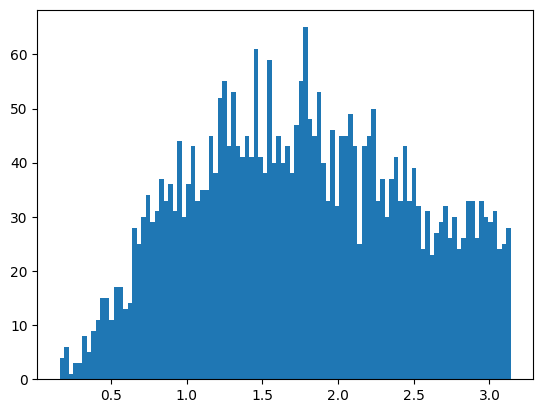

In [ ]:
plt.hist(geodesic_rot_distance(y_vals_orb[train_indices], y_pred_orb), bins=100);

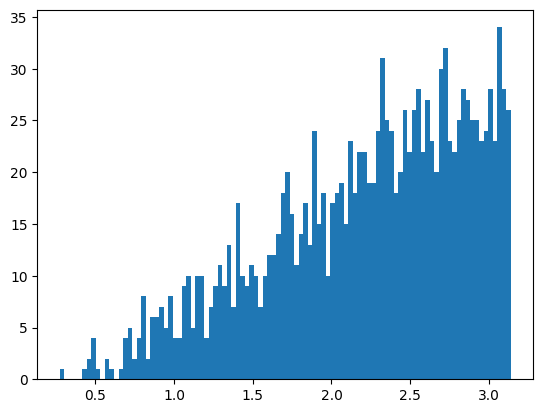

In [ ]:
plt.hist(geodesic_rot_distance(y_vals_orb[test_indices], y_pred_orb_test), bins=100);

In [ ]:
# other
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=10, max_features=150, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Ridge": RidgeCV(),
}

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(x_vals_orb[train_indices], y_vals_orb[train_indices])
    y_test_predict[name] = estimator.predict(x_vals_orb[test_indices])


print('l2 score on test, trees', sklearn.metrics.mean_squared_error(y_vals_orb[test_indices], y_test_predict['Extra trees'], squared=False))
print('l2 score on test, knn', sklearn.metrics.mean_squared_error(y_vals_orb[test_indices], y_test_predict['K-nn'], squared=False))
print('l2 score on test, Ridge', sklearn.metrics.mean_squared_error(y_vals_orb[test_indices], y_test_predict['Ridge'], squared=False))

l2 score on test, trees 0.522808522371871
l2 score on test, knn 0.54665506
l2 score on test, Ridge 0.552311365298598


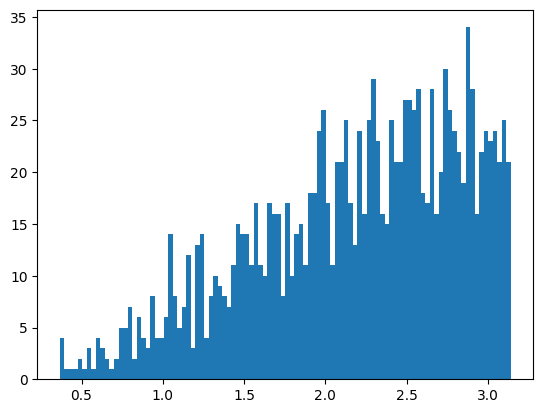

In [ ]:
plt.hist(geodesic_rot_distance(y_vals_orb[test_indices], y_test_predict['Extra trees']), bins=100);

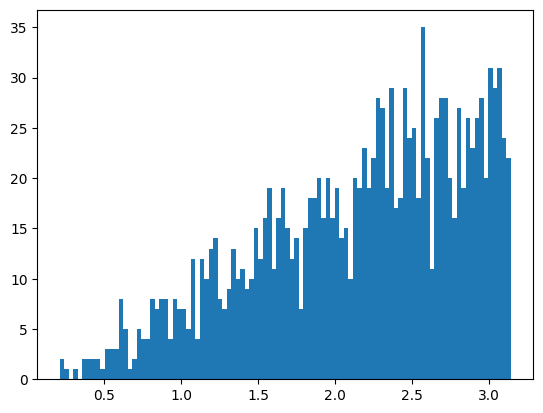

In [ ]:
plt.hist(geodesic_rot_distance(y_vals_orb[test_indices], y_test_predict['K-nn']), bins=100);

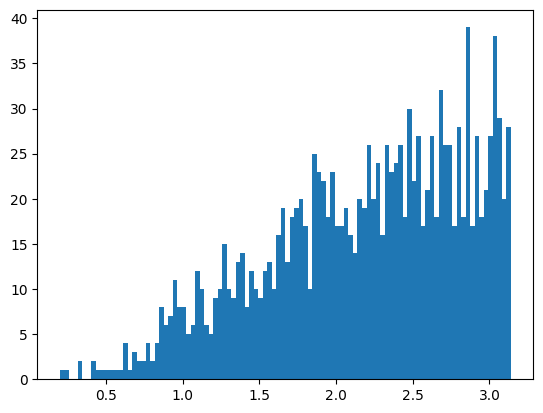

In [ ]:
plt.hist(geodesic_rot_distance(y_vals_orb[test_indices], y_test_predict['Ridge']), bins=100);

100%|██████████| 10000/10000 [01:28<00:00, 113.53it/s]


l2 score on test, Extra trees 0.5254663350121126


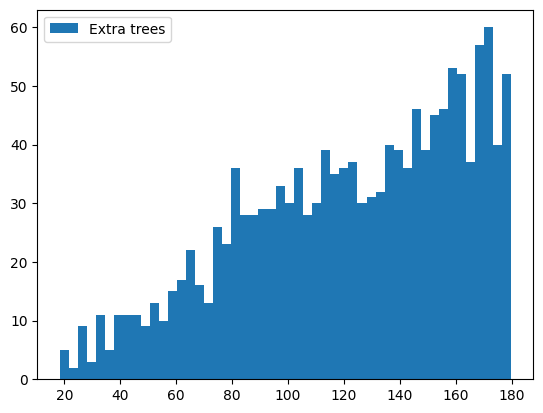

l2 score on test, K-nn 0.5459716


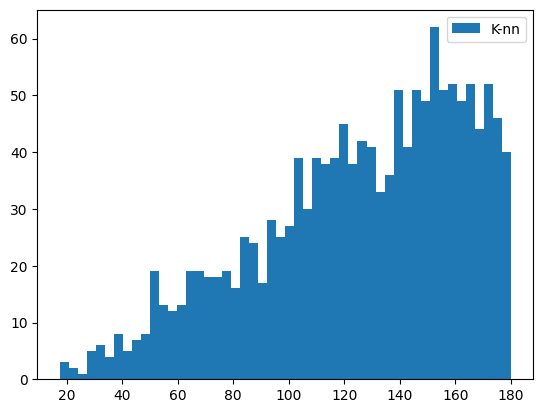

l2 score on test, Ridge 0.5005100157954225


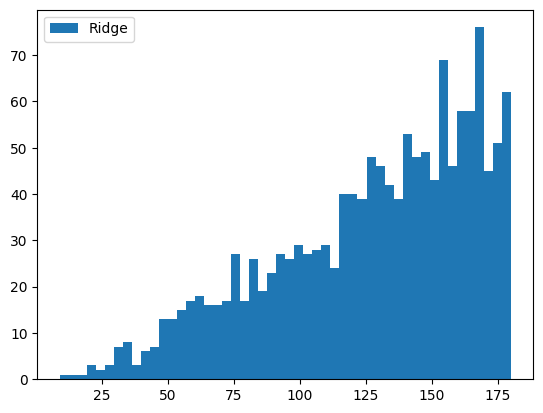

l2 score on test, Linear Regression 0.50039285


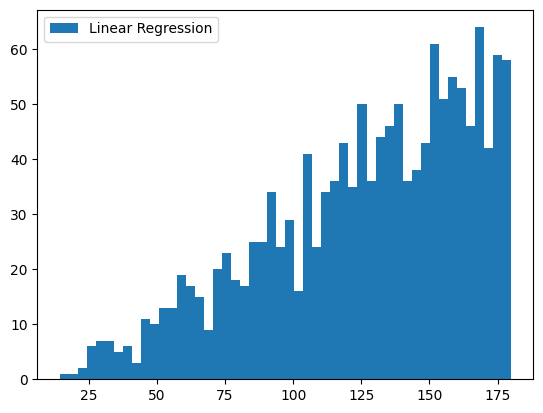

l2 score on test, Lasso Linear_0.01 0.5004935


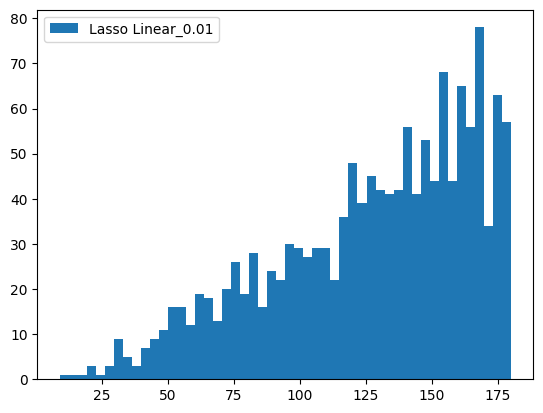

l2 score on test, Lasso Linear_0.1 0.5003667


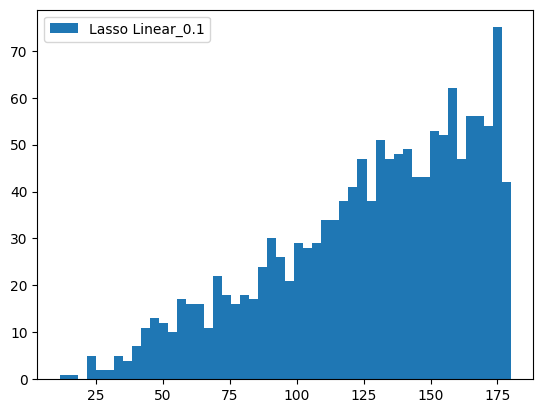

l2 score on test, Lasso Linear_0.5 0.50010055


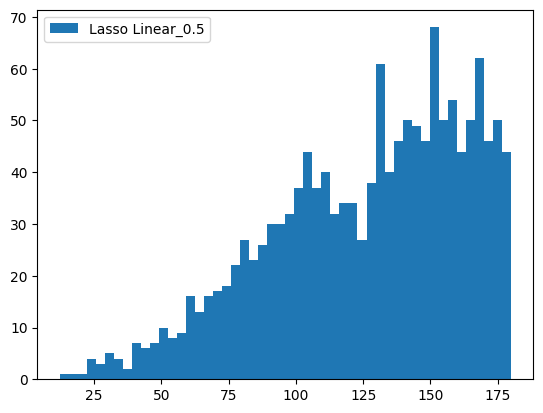

In [190]:

#### dimensions as a attitude estimator

path = "/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random_10k/data"
png_files = glob.glob(os.path.join(path, '*.png'))
json_files = glob.glob(os.path.join(path, '*.json'))

def extract_png_number(filename):
    match = re.search(r'(\d+).png$', filename)
    if match:   return int(match.group(1))
    else:       return -1
    
def extract_json_number(filename):
    match = re.search(r'(\d+).json$', filename)
    if match:   return int(match.group(1))
    else:       return -1

png_files.sort(key=extract_png_number)
json_files.sort(key=extract_json_number)



def model_dimensions(img_np:np.ndarray):
    # assert img.min() == 0 and img.max() == 1

    # create object mask
    img_np_copy = img_np.copy()
    img_np_copy[np.where(img_np_copy<0.01)] = 0
    img_np_copy[np.where(img_np_copy>0.01)] = 1

    # determine object dimensions
    y,x,c = np.where(img_np_copy>0)
    ymin, ymax = np.min(y), np.max(y)
    xmin, xmax = np.min(x), np.max(x)
    height = ymax - ymin
    width = xmax - xmin

    # determine horizontal-wise pixel sums
    img_np_copy_bw = rgb2gray(img_np_copy.copy())
    horiz_sums = np.sum(img_np_copy_bw, axis=0)
    horiz_sums = horiz_sums/np.max(horiz_sums)
    horiz_sums = [i for i in horiz_sums]

    # determine vertical-wise pixel sums
    vert_sums = np.sum(img_np_copy_bw, axis=1)
    vert_sums = vert_sums/np.max(vert_sums)
    vert_sums = [i for i in vert_sums]

    return [height] + [width] + [ymin] + [ymax] + [xmin] + [xmax]


# extract translation (xvals) from the data
import json
poses = []

for json_f in tqdm(json_files):
    with open(json_f) as f: poses.append(json.load(f)['pose'])

poses = np.array(poses, dtype=np.float32)
y_vals_dims = poses


# extract dimensions (yvals) from the data

dimensions = []
for png_f in tqdm(png_files):
    img = Image.open(png_f).convert('RGB')
    img_np = np.array(img)/255.0
    dimensions.append(model_dimensions(img_np))
dimensions = np.array(dimensions, dtype=np.float32)
x_vals_dims = dimensions


# other
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=100, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Ridge": RidgeCV(),
    "Linear Regression": LinearRegression(),
    "Lasso Linear_0.01": linear_model.LassoLars(alpha=0.01),
    "Lasso Linear_0.1": linear_model.LassoLars(alpha=0.1),
    "Lasso Linear_0.5": linear_model.LassoLars(alpha=0.5),
}

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(x_vals_dims[train_indices], y_vals_dims[train_indices])
    y_test_predict[name] = estimator.predict(x_vals_dims[test_indices])
    print(f'l2 score on test, {name}', sklearn.metrics.mean_squared_error(y_vals_dims[test_indices], y_test_predict[name], squared=False))
    plt.hist(geodesic_rot_distance(y_vals_dims[test_indices], y_test_predict[name])*180/np.pi, bins=50, alpha=1, label=name)
    plt.legend()
    plt.show()

In [192]:
y_vals_dims.shape, x_vals_dims.shape

((10000, 4), (10000, 6))

100%|██████████| 10000/10000 [01:18<00:00, 127.43it/s]


l2 score on test, Extra trees 0.5140949621937937


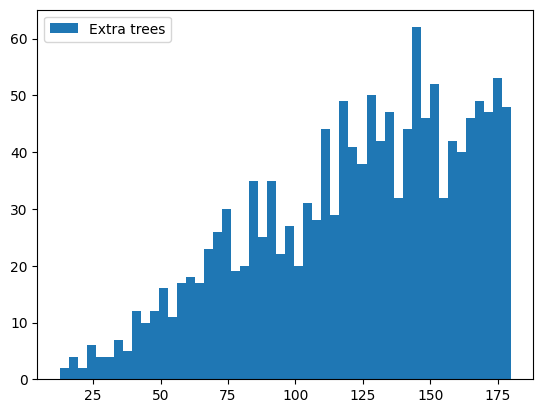

l2 score on test, K-nn 0.54519105


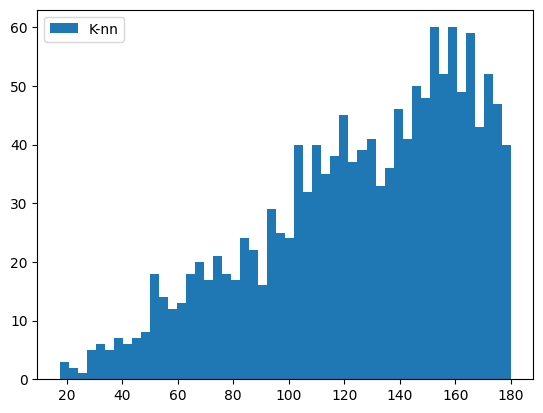

l2 score on test, Ridge 0.504061977628835


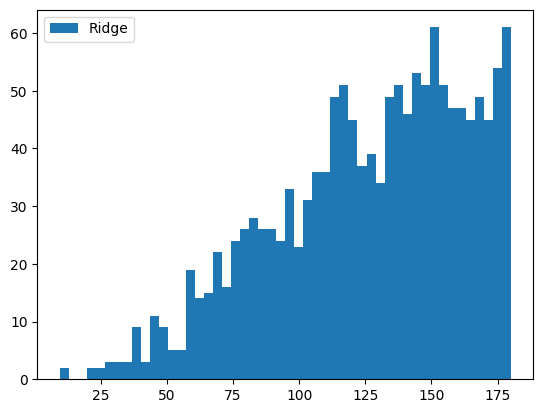

l2 score on test, Linear Regression 0.5345913


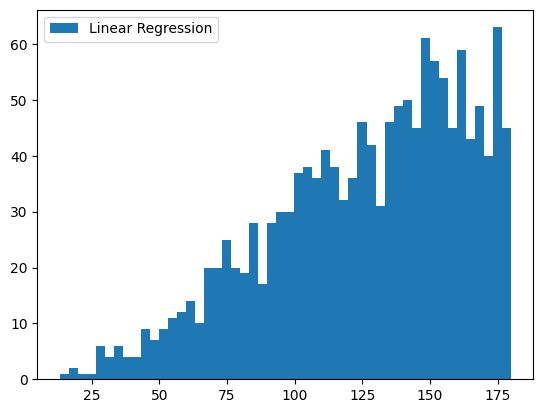

l2 score on test, Lasso Linear_0.01 0.5004935


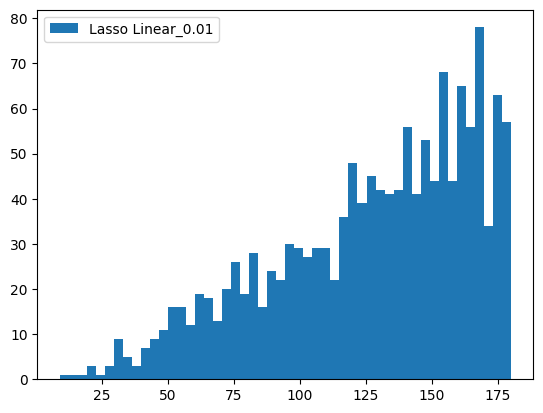

l2 score on test, Lasso Linear_0.1 0.5003667


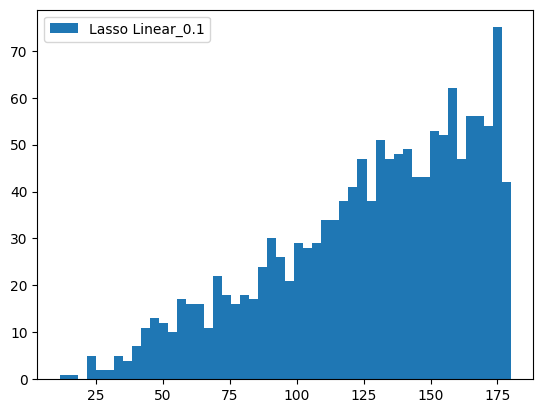

l2 score on test, Lasso Linear_0.5 0.50010055


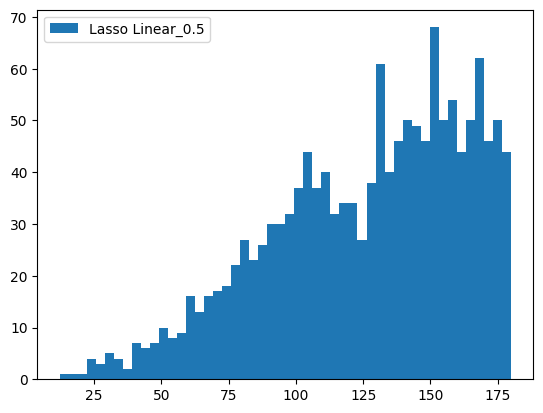

In [193]:

#### dimensions as a attitude estimator

path = "/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random_10k/data"
png_files = glob.glob(os.path.join(path, '*.png'))
json_files = glob.glob(os.path.join(path, '*.json'))

def extract_png_number(filename):
    match = re.search(r'(\d+).png$', filename)
    if match:   return int(match.group(1))
    else:       return -1
    
def extract_json_number(filename):
    match = re.search(r'(\d+).json$', filename)
    if match:   return int(match.group(1))
    else:       return -1

png_files.sort(key=extract_png_number)
json_files.sort(key=extract_json_number)



def model_dimensions(img_np:np.ndarray):
    # assert img.min() == 0 and img.max() == 1

    # create object mask
    img_np_copy = img_np.copy()
    img_np_copy[np.where(img_np_copy<0.01)] = 0
    img_np_copy[np.where(img_np_copy>0.01)] = 1

    # determine object dimensions
    y,x,c = np.where(img_np_copy>0)
    ymin, ymax = np.min(y), np.max(y)
    xmin, xmax = np.min(x), np.max(x)
    height = ymax - ymin
    width = xmax - xmin

    # determine horizontal-wise pixel sums
    img_np_copy_bw = rgb2gray(img_np_copy.copy())
    horiz_sums = np.sum(img_np_copy_bw, axis=0)
    horiz_sums = horiz_sums/np.max(horiz_sums)
    horiz_sums = [i for i in horiz_sums]

    # determine vertical-wise pixel sums
    vert_sums = np.sum(img_np_copy_bw, axis=1)
    vert_sums = vert_sums/np.max(vert_sums)
    vert_sums = [i for i in vert_sums]

    return [height] + [width] + [ymin] + [ymax] + [xmin] + [xmax] + horiz_sums


# extract translation (xvals) from the data
import json
poses = []

for json_f in tqdm(json_files):
    with open(json_f) as f: poses.append(json.load(f)['pose'])

poses = np.array(poses, dtype=np.float32)
y_vals_dims = poses


# extract dimensions (yvals) from the data

dimensions = []
for png_f in tqdm(png_files):
    img = Image.open(png_f).convert('RGB')
    img_np = np.array(img)/255.0
    dimensions.append(model_dimensions(img_np))
dimensions = np.array(dimensions, dtype=np.float32)
x_vals_dims = dimensions


# other
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=100, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Ridge": RidgeCV(),
    "Linear Regression": LinearRegression(),
    "Lasso Linear_0.01": linear_model.LassoLars(alpha=0.01),
    "Lasso Linear_0.1": linear_model.LassoLars(alpha=0.1),
    "Lasso Linear_0.5": linear_model.LassoLars(alpha=0.5),
}

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(x_vals_dims[train_indices], y_vals_dims[train_indices])
    y_test_predict[name] = estimator.predict(x_vals_dims[test_indices])
    print(f'l2 score on test, {name}', sklearn.metrics.mean_squared_error(y_vals_dims[test_indices], y_test_predict[name], squared=False))
    plt.hist(geodesic_rot_distance(y_vals_dims[test_indices], y_test_predict[name])*180/np.pi, bins=50, alpha=1, label=name)
    plt.legend()
    plt.show()


100%|██████████| 10000/10000 [01:09<00:00, 143.47it/s]


l2 score on test, Extra trees 0.5139846159120314


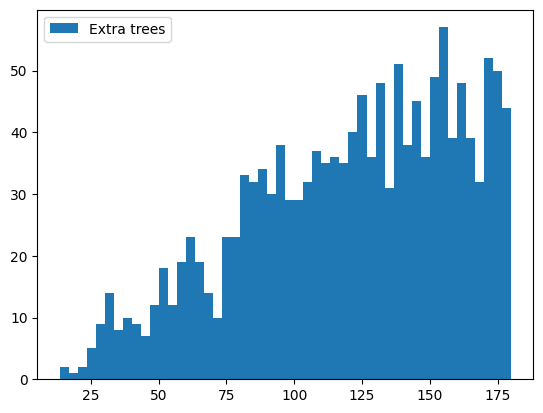

l2 score on test, K-nn 0.5455882


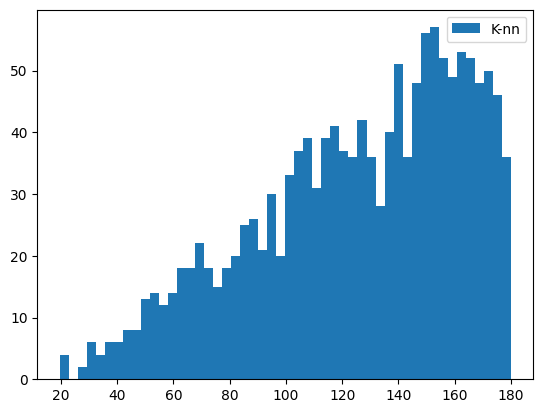

l2 score on test, Ridge 0.5053818004745791


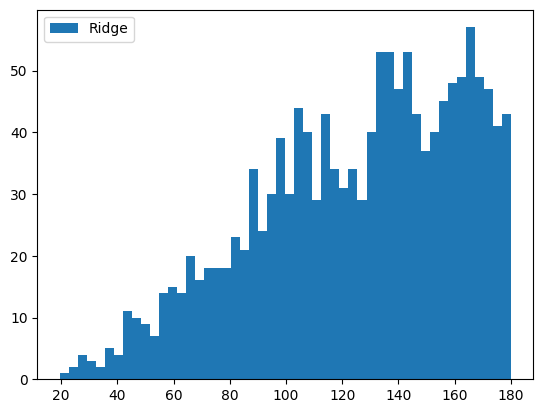

l2 score on test, Linear Regression 0.5531219


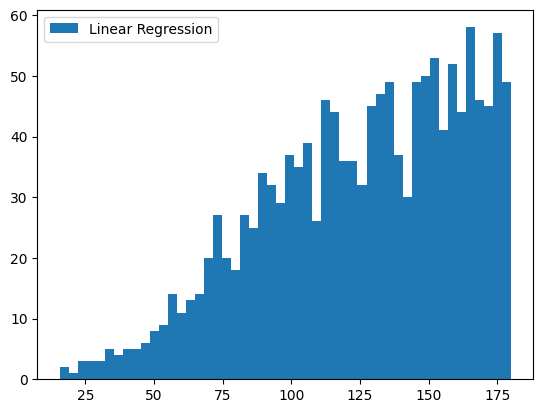

l2 score on test, Lasso Linear_0.01 0.5004936


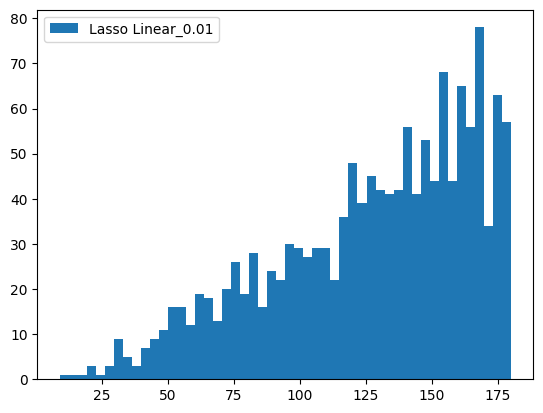

l2 score on test, Lasso Linear_0.1 0.5003667


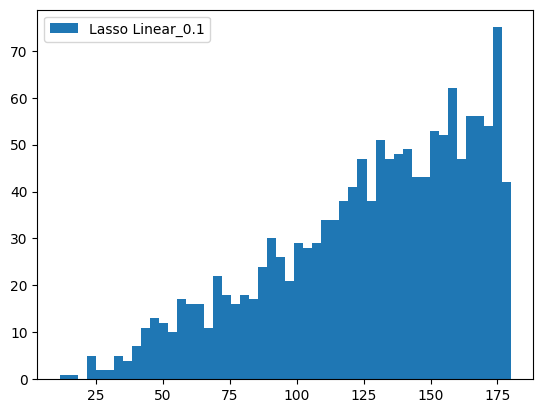

l2 score on test, Lasso Linear_0.5 0.50010055


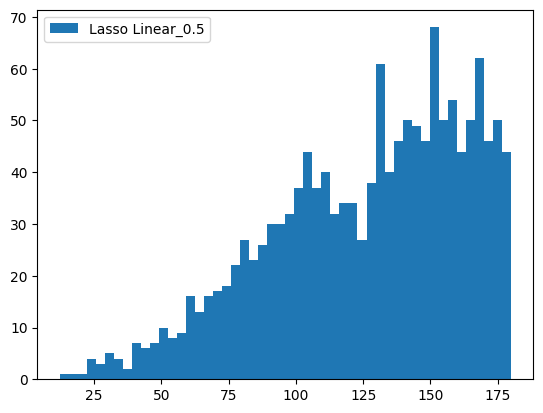

In [194]:

#### dimensions as a attitude estimator

path = "/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random_10k/data"
png_files = glob.glob(os.path.join(path, '*.png'))
json_files = glob.glob(os.path.join(path, '*.json'))

def extract_png_number(filename):
    match = re.search(r'(\d+).png$', filename)
    if match:   return int(match.group(1))
    else:       return -1
    
def extract_json_number(filename):
    match = re.search(r'(\d+).json$', filename)
    if match:   return int(match.group(1))
    else:       return -1

png_files.sort(key=extract_png_number)
json_files.sort(key=extract_json_number)



def model_dimensions(img_np:np.ndarray):
    # assert img.min() == 0 and img.max() == 1

    # create object mask
    img_np_copy = img_np.copy()
    img_np_copy[np.where(img_np_copy<0.01)] = 0
    img_np_copy[np.where(img_np_copy>0.01)] = 1

    # determine object dimensions
    y,x,c = np.where(img_np_copy>0)
    ymin, ymax = np.min(y), np.max(y)
    xmin, xmax = np.min(x), np.max(x)
    height = ymax - ymin
    width = xmax - xmin

    # determine horizontal-wise pixel sums
    img_np_copy_bw = rgb2gray(img_np_copy.copy())
    horiz_sums = np.sum(img_np_copy_bw, axis=0)
    horiz_sums = horiz_sums/np.max(horiz_sums)
    horiz_sums = [i for i in horiz_sums]

    # determine vertical-wise pixel sums
    vert_sums = np.sum(img_np_copy_bw, axis=1)
    vert_sums = vert_sums/np.max(vert_sums)
    vert_sums = [i for i in vert_sums]

    return [height] + [width] + [ymin] + [ymax] + [xmin] + [xmax] + vert_sums


# extract translation (xvals) from the data
import json
poses = []

for json_f in tqdm(json_files):
    with open(json_f) as f: poses.append(json.load(f)['pose'])

poses = np.array(poses, dtype=np.float32)
y_vals_dims = poses


# extract dimensions (yvals) from the data

dimensions = []
for png_f in tqdm(png_files):
    img = Image.open(png_f).convert('RGB')
    img_np = np.array(img)/255.0
    dimensions.append(model_dimensions(img_np))
dimensions = np.array(dimensions, dtype=np.float32)
x_vals_dims = dimensions


# other
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=100, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Ridge": RidgeCV(),
    "Linear Regression": LinearRegression(),
    "Lasso Linear_0.01": linear_model.LassoLars(alpha=0.01),
    "Lasso Linear_0.1": linear_model.LassoLars(alpha=0.1),
    "Lasso Linear_0.5": linear_model.LassoLars(alpha=0.5),
}

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(x_vals_dims[train_indices], y_vals_dims[train_indices])
    y_test_predict[name] = estimator.predict(x_vals_dims[test_indices])
    print(f'l2 score on test, {name}', sklearn.metrics.mean_squared_error(y_vals_dims[test_indices], y_test_predict[name], squared=False))
    plt.hist(geodesic_rot_distance(y_vals_dims[test_indices], y_test_predict[name])*180/np.pi, bins=50, alpha=1, label=name)
    plt.legend()
    plt.show()


100%|██████████| 10000/10000 [01:22<00:00, 121.94it/s]


l2 score on test, Extra trees 0.509370672880246


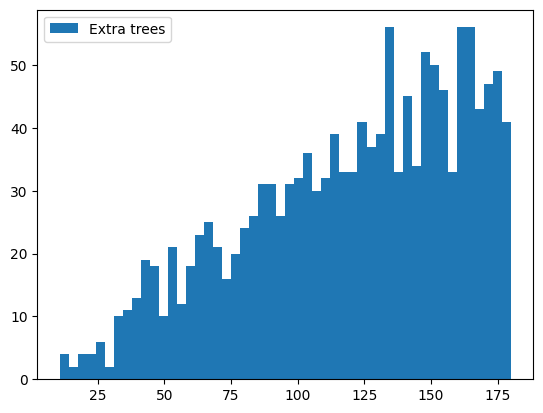

l2 score on test, K-nn 0.54555297


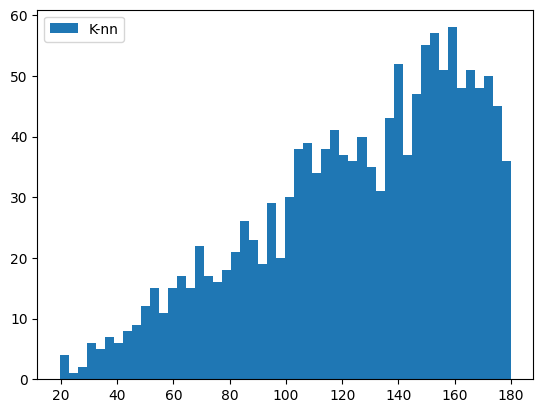

l2 score on test, Ridge 0.5090235918443383


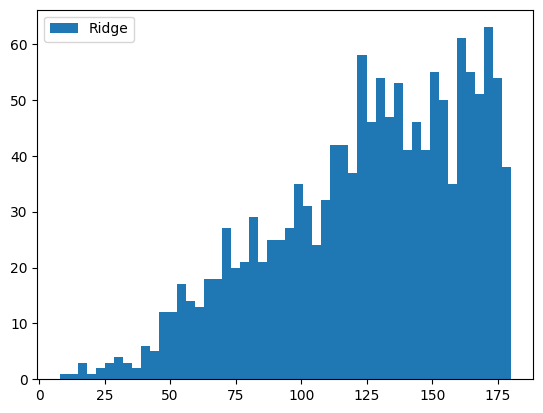

l2 score on test, Linear Regression 0.55007935


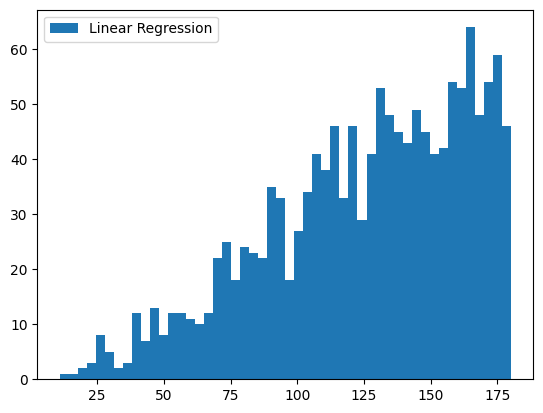

l2 score on test, Lasso Linear_0.01 0.5004936


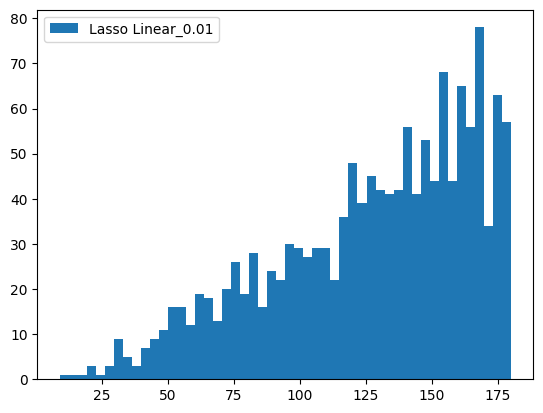

l2 score on test, Lasso Linear_0.1 0.5003667


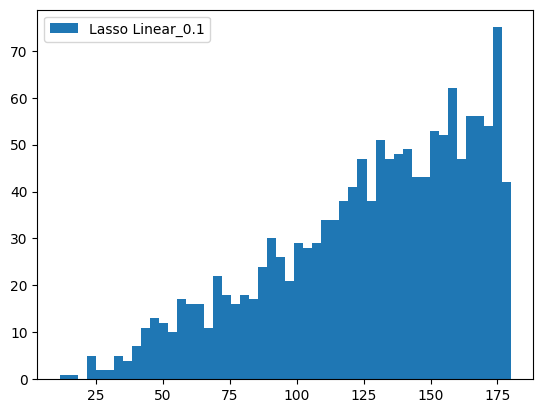

l2 score on test, Lasso Linear_0.5 0.50010055


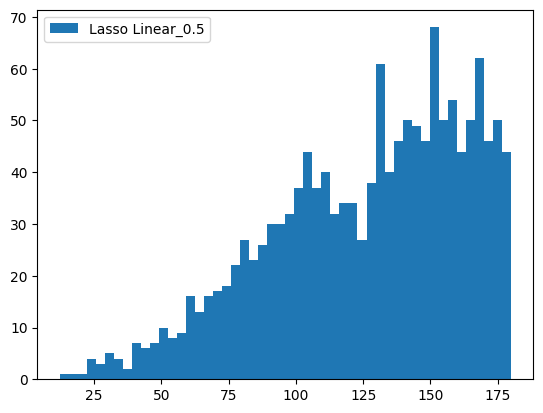

In [195]:

#### dimensions as a attitude estimator

path = "/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random_10k/data"
png_files = glob.glob(os.path.join(path, '*.png'))
json_files = glob.glob(os.path.join(path, '*.json'))

def extract_png_number(filename):
    match = re.search(r'(\d+).png$', filename)
    if match:   return int(match.group(1))
    else:       return -1
    
def extract_json_number(filename):
    match = re.search(r'(\d+).json$', filename)
    if match:   return int(match.group(1))
    else:       return -1

png_files.sort(key=extract_png_number)
json_files.sort(key=extract_json_number)



def model_dimensions(img_np:np.ndarray):
    # assert img.min() == 0 and img.max() == 1

    # create object mask
    img_np_copy = img_np.copy()
    img_np_copy[np.where(img_np_copy<0.01)] = 0
    img_np_copy[np.where(img_np_copy>0.01)] = 1

    # determine object dimensions
    y,x,c = np.where(img_np_copy>0)
    ymin, ymax = np.min(y), np.max(y)
    xmin, xmax = np.min(x), np.max(x)
    height = ymax - ymin
    width = xmax - xmin

    # determine horizontal-wise pixel sums
    img_np_copy_bw = rgb2gray(img_np_copy.copy())
    horiz_sums = np.sum(img_np_copy_bw, axis=0)
    horiz_sums = horiz_sums/np.max(horiz_sums)
    horiz_sums = [i for i in horiz_sums]

    # determine vertical-wise pixel sums
    vert_sums = np.sum(img_np_copy_bw, axis=1)
    vert_sums = vert_sums/np.max(vert_sums)
    vert_sums = [i for i in vert_sums]

    return [height] + [width] + [ymin] + [ymax] + [xmin] + [xmax] + horiz_sums + vert_sums


# extract translation (xvals) from the data
import json
poses = []

for json_f in tqdm(json_files):
    with open(json_f) as f: poses.append(json.load(f)['pose'])

poses = np.array(poses, dtype=np.float32)
y_vals_dims = poses


# extract dimensions (yvals) from the data

dimensions = []
for png_f in tqdm(png_files):
    img = Image.open(png_f).convert('RGB')
    img_np = np.array(img)/255.0
    dimensions.append(model_dimensions(img_np))
dimensions = np.array(dimensions, dtype=np.float32)
x_vals_dims = dimensions


# other
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=100, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Ridge": RidgeCV(),
    "Linear Regression": LinearRegression(),
    "Lasso Linear_0.01": linear_model.LassoLars(alpha=0.01),
    "Lasso Linear_0.1": linear_model.LassoLars(alpha=0.1),
    "Lasso Linear_0.5": linear_model.LassoLars(alpha=0.5),
}

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(x_vals_dims[train_indices], y_vals_dims[train_indices])
    y_test_predict[name] = estimator.predict(x_vals_dims[test_indices])
    print(f'l2 score on test, {name}', sklearn.metrics.mean_squared_error(y_vals_dims[test_indices], y_test_predict[name], squared=False))
    plt.hist(geodesic_rot_distance(y_vals_dims[test_indices], y_test_predict[name])*180/np.pi, bins=50, alpha=1, label=name)
    plt.legend()
    plt.show()


100%|██████████| 10000/10000 [01:16<00:00, 130.52it/s]


l2 score on test, Extra trees 0.5098926538474772


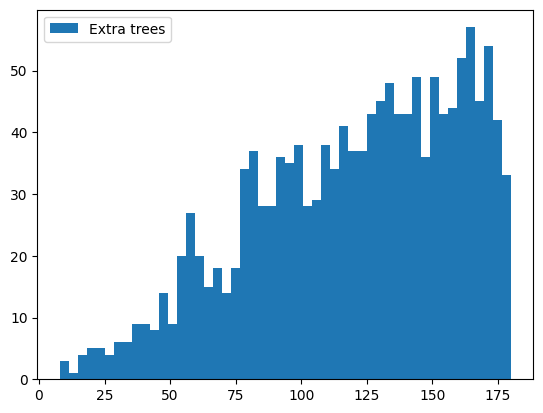

l2 score on test, K-nn 0.54564357


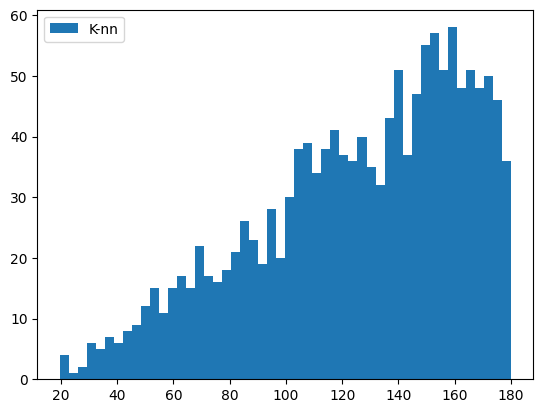

l2 score on test, Ridge 0.50913267234643


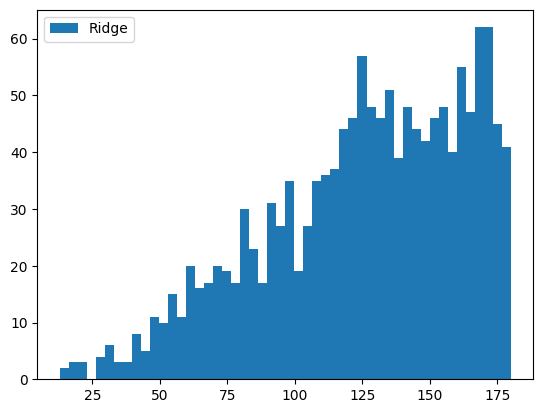

l2 score on test, Linear Regression 0.55331993


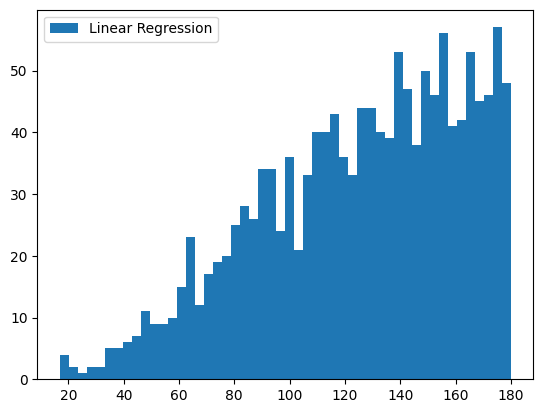

l2 score on test, Lasso Linear_0.01 0.5004936


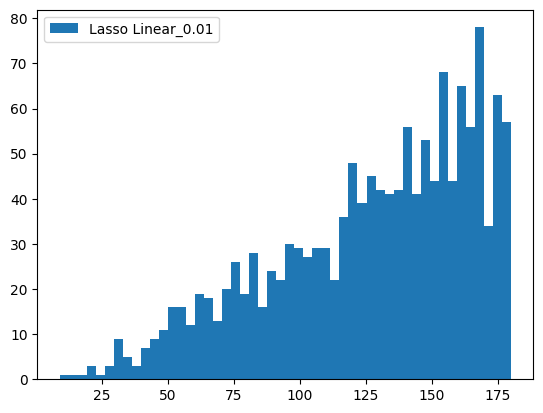

l2 score on test, Lasso Linear_0.1 0.5003667


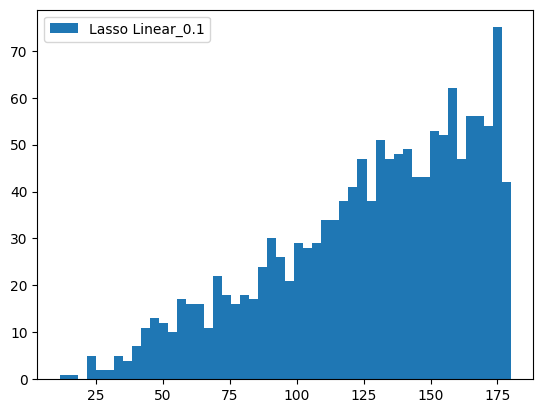

l2 score on test, Lasso Linear_0.5 0.50010055


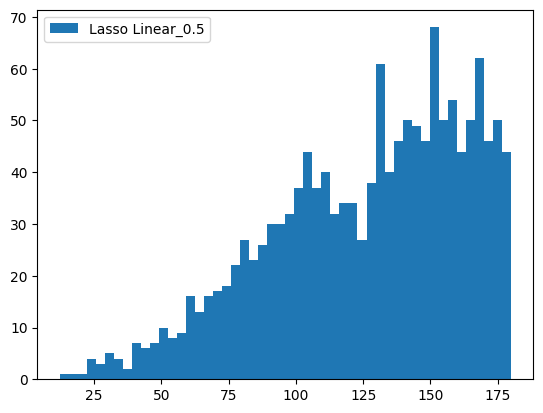

In [196]:

#### dimensions as a attitude estimator

path = "/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random_10k/data"
png_files = glob.glob(os.path.join(path, '*.png'))
json_files = glob.glob(os.path.join(path, '*.json'))

def extract_png_number(filename):
    match = re.search(r'(\d+).png$', filename)
    if match:   return int(match.group(1))
    else:       return -1
    
def extract_json_number(filename):
    match = re.search(r'(\d+).json$', filename)
    if match:   return int(match.group(1))
    else:       return -1

png_files.sort(key=extract_png_number)
json_files.sort(key=extract_json_number)



def model_dimensions(img_np:np.ndarray):
    # assert img.min() == 0 and img.max() == 1

    # create object mask
    img_np_copy = img_np.copy()
    img_np_copy[np.where(img_np_copy<0.01)] = 0
    img_np_copy[np.where(img_np_copy>0.01)] = 1

    # determine object dimensions
    y,x,c = np.where(img_np_copy>0)
    ymin, ymax = np.min(y), np.max(y)
    xmin, xmax = np.min(x), np.max(x)
    height = ymax - ymin
    width = xmax - xmin

    # determine horizontal-wise pixel sums
    img_np_copy_bw = rgb2gray(img_np_copy.copy())
    horiz_sums = np.sum(img_np_copy_bw, axis=0)
    horiz_sums = horiz_sums/np.max(horiz_sums)
    horiz_sums = [i for i in horiz_sums]

    # determine vertical-wise pixel sums
    vert_sums = np.sum(img_np_copy_bw, axis=1)
    vert_sums = vert_sums/np.max(vert_sums)
    vert_sums = [i for i in vert_sums]

    return [height] + [width] + [ymin] + [ymax] + [xmin] + [xmax] + [height/width] + horiz_sums + vert_sums


# extract translation (xvals) from the data
import json
poses = []

for json_f in tqdm(json_files):
    with open(json_f) as f: poses.append(json.load(f)['pose'])

poses = np.array(poses, dtype=np.float32)
y_vals_dims = poses


# extract dimensions (yvals) from the data

dimensions = []
for png_f in tqdm(png_files):
    img = Image.open(png_f).convert('RGB')
    img_np = np.array(img)/255.0
    dimensions.append(model_dimensions(img_np))
dimensions = np.array(dimensions, dtype=np.float32)
x_vals_dims = dimensions


# other
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=100, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Ridge": RidgeCV(),
    "Linear Regression": LinearRegression(),
    "Lasso Linear_0.01": linear_model.LassoLars(alpha=0.01),
    "Lasso Linear_0.1": linear_model.LassoLars(alpha=0.1),
    "Lasso Linear_0.5": linear_model.LassoLars(alpha=0.5),
}

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(x_vals_dims[train_indices], y_vals_dims[train_indices])
    y_test_predict[name] = estimator.predict(x_vals_dims[test_indices])
    print(f'l2 score on test, {name}', sklearn.metrics.mean_squared_error(y_vals_dims[test_indices], y_test_predict[name], squared=False))
    plt.hist(geodesic_rot_distance(y_vals_dims[test_indices], y_test_predict[name])*180/np.pi, bins=50, alpha=1, label=name)
    plt.legend()
    plt.show()


l2 score on test, decision trees 0.5009052225788745


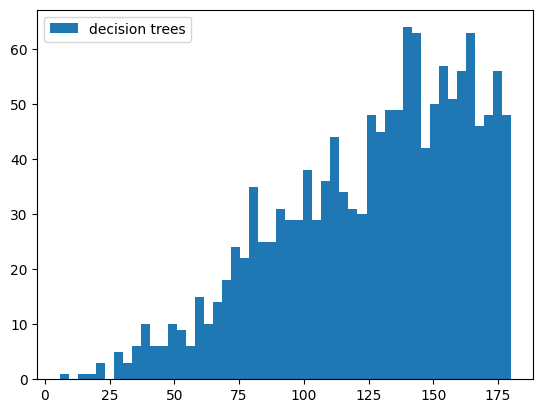

l2 score on test, decision trees 0.5019439842972288


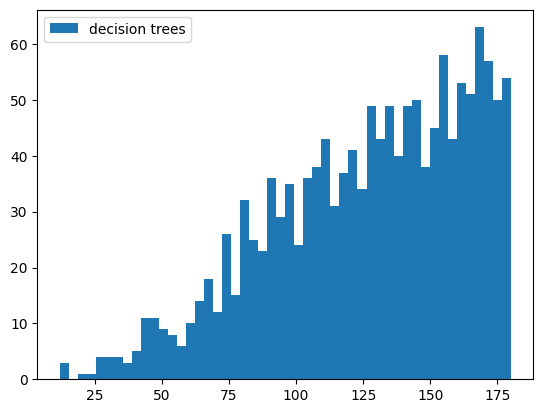

l2 score on test, decision trees 0.5026799272401864


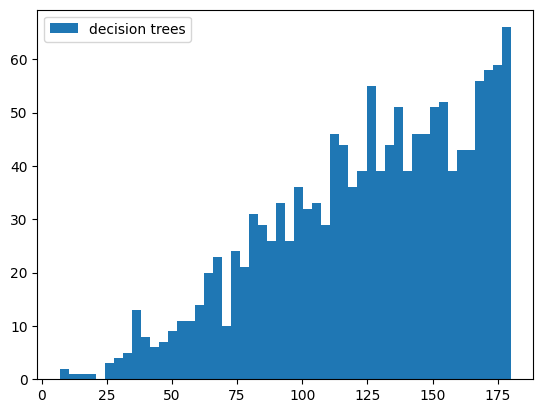

l2 score on test, decision trees 0.5053422252099188


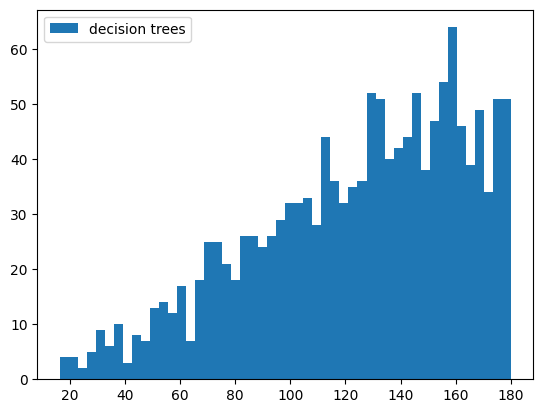

l2 score on test, decision trees 0.5107852947099908


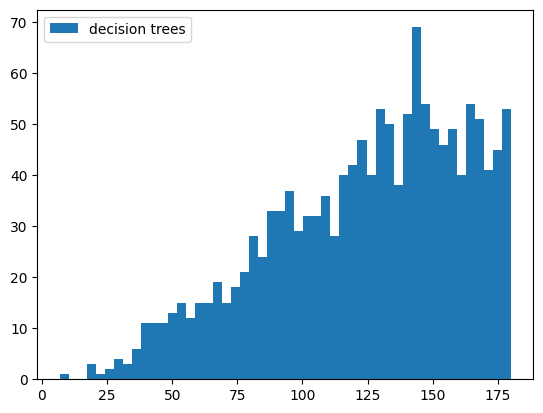

l2 score on test, decision trees 0.5150402068119757


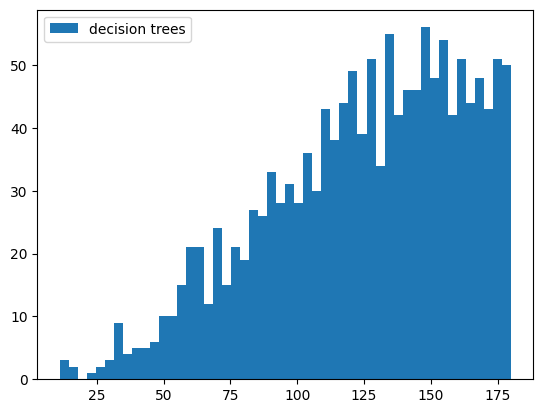

In [225]:
from sklearn.tree import DecisionTreeRegressor

for depth in range(1, 7):

    regr_3 = DecisionTreeRegressor(max_depth=depth)
    regr_3.fit(x_vals_dims[train_indices], y_vals_dims[train_indices])
    y_test_predict = regr_3.predict(x_vals_dims[test_indices])
    name = 'decision trees'
    print(f'l2 score on test, {name}', sklearn.metrics.mean_squared_error(y_vals_dims[test_indices], y_test_predict, squared=False))
    plt.hist(geodesic_rot_distance(y_vals_dims[test_indices], y_test_predict)*180/np.pi, bins=50, alpha=1, label=name)
    plt.legend()
    plt.show()


In [ ]:
estimator.fit(x_vals_dims[train_indices], y_vals_dims[train_indices])
y_test_predict[name] = estimator.predict(x_vals_dims[test_indices])

In [159]:
plt.close('all')

In [18]:
# mlp

import random
n = len(x_vals_dims)
n_train = int(0.7*n)
indices = list(range(n))
random.shuffle(indices)
train_indices = indices[:n_train]
test_indices = indices[n_train:]




#### dimensions as a attitude estimator
import glob
import os
import re
import numpy as np
from tqdm import tqdm
from PIL import Image
from skimage.color import rgb2gray


path = "/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random_10k/data"
png_files = glob.glob(os.path.join(path, '*.png'))
json_files = glob.glob(os.path.join(path, '*.json'))

def extract_png_number(filename):
    match = re.search(r'(\d+).png$', filename)
    if match:   return int(match.group(1))
    else:       return -1
    
def extract_json_number(filename):
    match = re.search(r'(\d+).json$', filename)
    if match:   return int(match.group(1))
    else:       return -1

png_files.sort(key=extract_png_number)
json_files.sort(key=extract_json_number)



def model_dimensions(img_np:np.ndarray):
    # assert img.min() == 0 and img.max() == 1

    # create object mask
    img_np_copy = img_np.copy()
    img_np_copy[np.where(img_np_copy<0.01)] = 0
    img_np_copy[np.where(img_np_copy>0.01)] = 1

    # determine object dimensions
    y,x,c = np.where(img_np_copy>0)
    ymin, ymax = np.min(y), np.max(y)
    xmin, xmax = np.min(x), np.max(x)
    height = ymax - ymin
    width = xmax - xmin

    # determine horizontal-wise pixel sums
    img_np_copy_bw = rgb2gray(img_np_copy.copy())
    horiz_sums = np.sum(img_np_copy_bw, axis=0)
    horiz_sums = horiz_sums/np.max(horiz_sums)
    horiz_sums = [i for i in horiz_sums]

    # determine vertical-wise pixel sums
    vert_sums = np.sum(img_np_copy_bw, axis=1)
    vert_sums = vert_sums/np.max(vert_sums)
    vert_sums = [i for i in vert_sums]

    return [height] + [width] + [ymin] + [ymax] + [xmin] + [xmax] + [height/width] + horiz_sums + vert_sums


# extract poses (xvals) from the data
import json
poses = []

for json_f in tqdm(json_files):
    with open(json_f) as f: poses.append(json.load(f)['pose'])

poses = np.array(poses, dtype=np.float32)
y_vals_dims = poses


# extract dimensions (yvals) from the data

dimensions = []
for png_f in tqdm(png_files):
    img = Image.open(png_f).convert('RGB')
    img_np = np.array(img)/255.0
    dimensions.append(model_dimensions(img_np))
dimensions = np.array(dimensions, dtype=np.float32)
x_vals_dims = dimensions



100%|██████████| 10000/10000 [01:05<00:00, 153.28it/s]


NameError: name 'sklearn' is not defined

In [21]:
import torch
def geodesic_rot_distance(target, pred):
    
    target = torch.tensor(target)
    pred = torch.tensor(pred)
    
    ndims = len(target.shape)
    # first, normalise each quaternion
    pred   = torch.nn.functional.normalize(pred, p=2, dim=ndims-1)
    target = torch.nn.functional.normalize(target, p=2, dim=ndims-1) # <- targets are already normalised

    # compute angular distance
    inner_prod_square = torch.square(torch.sum(pred*target, dim=ndims-1))
    theta = torch.arccos(2*inner_prod_square-1)
    return theta

l2 score on test, mlp 0.6266409


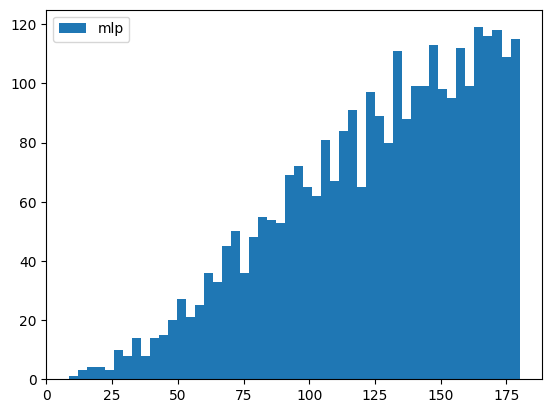

In [22]:
# mlp
import sklearn
from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

scaler = StandardScaler()
scaler.fit(x_vals_dims[train_indices])
x_train = scaler.transform(x_vals_dims[train_indices])
x_test = scaler.transform(x_vals_dims[test_indices])

clf = MLPRegressor(random_state=1, max_iter=500).fit(x_train, y_vals_dims[train_indices])
y_pred = clf.predict(x_test)

name='mlp'
print(f'l2 score on test, {name}', sklearn.metrics.mean_squared_error(y_vals_dims[test_indices], y_pred, squared=False))
plt.hist(geodesic_rot_distance(y_vals_dims[test_indices], y_pred)*180/np.pi, bins=50, alpha=1, label=name)
plt.legend()
plt.show()

l2 score on test, mlp 0.7138554


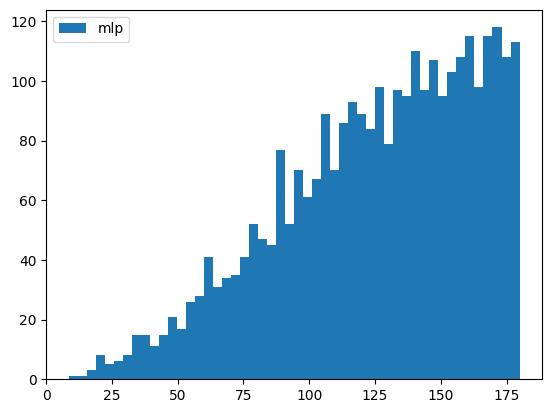

In [23]:
# mlp - 2 layer

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

scaler = StandardScaler()
scaler.fit(x_vals_dims[train_indices])
x_train = scaler.transform(x_vals_dims[train_indices])
x_test = scaler.transform(x_vals_dims[test_indices])

clf = MLPRegressor([200, 100], random_state=1, max_iter=500).fit(x_train, y_vals_dims[train_indices])
y_pred = clf.predict(x_test)
name = 'mlp'
print(f'l2 score on test, {name}', sklearn.metrics.mean_squared_error(y_vals_dims[test_indices], y_pred, squared=False))
plt.hist(geodesic_rot_distance(y_vals_dims[test_indices], y_pred)*180/np.pi, bins=50, alpha=1, label=name)
plt.legend()
plt.show()


l2 score on test, mlp 0.6695247


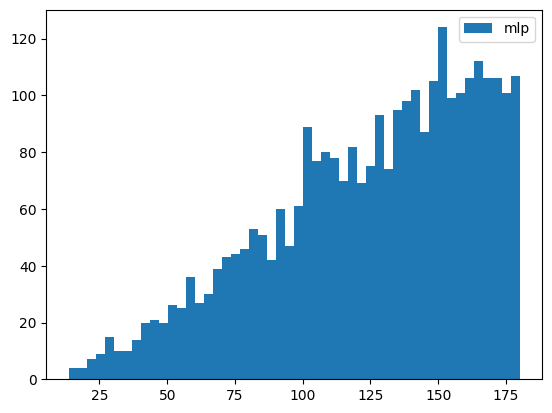

In [24]:
# mlp - 3 layer

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

scaler = StandardScaler()
scaler.fit(x_vals_dims[train_indices])
x_train = scaler.transform(x_vals_dims[train_indices])
x_test = scaler.transform(x_vals_dims[test_indices])

clf = MLPRegressor([200, 200, 100], random_state=1, max_iter=500).fit(x_train, y_vals_dims[train_indices])
y_pred = clf.predict(x_test)

print(f'l2 score on test, {name}', sklearn.metrics.mean_squared_error(y_vals_dims[test_indices], y_pred, squared=False))
plt.hist(geodesic_rot_distance(y_vals_dims[test_indices], y_pred)*180/np.pi, bins=50, alpha=1, label=name)
plt.legend()
plt.show()


100%|██████████| 10000/10000 [12:15<00:00, 13.60it/s]


l2 score on test, Lasso Linear_0.5 0.7742035


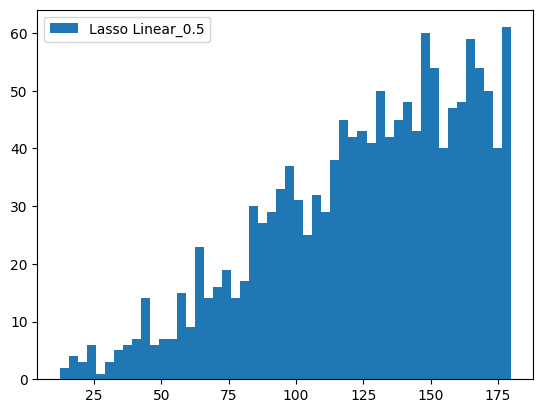

In [199]:
# mlp

#### alternate features

path = "/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random_10k/data"
png_files = glob.glob(os.path.join(path, '*.png'))
json_files = glob.glob(os.path.join(path, '*.json'))

def extract_png_number(filename):
    match = re.search(r'(\d+).png$', filename)
    if match:   return int(match.group(1))
    else:       return -1
    
def extract_json_number(filename):
    match = re.search(r'(\d+).json$', filename)
    if match:   return int(match.group(1))
    else:       return -1

png_files.sort(key=extract_png_number)
json_files.sort(key=extract_json_number)



n_keypoints = 10
descriptor_extractor = ORB(n_keypoints=n_keypoints)
def model_dimensions(img_np:np.ndarray):
    # assert img.min() == 0 and img.max() == 1

    # create object mask
    img_np_copy = img_np.copy()
    img_np_copy[np.where(img_np_copy<0.01)] = 0
    img_np_copy[np.where(img_np_copy>0.01)] = 1

    # determine object dimensions
    y,x,c = np.where(img_np_copy>0)
    ymin, ymax = np.min(y), np.max(y)
    xmin, xmax = np.min(x), np.max(x)
    height = ymax - ymin
    width = xmax - xmin

    # determine horizontal-wise pixel sums
    img_np_copy_bw = rgb2gray(img_np_copy.copy())
    horiz_sums = np.sum(img_np_copy_bw, axis=0)
    horiz_sums = horiz_sums/np.max(horiz_sums)
    horiz_sums = [i for i in horiz_sums]

    # determine vertical-wise pixel sums
    vert_sums = np.sum(img_np_copy_bw, axis=1)
    vert_sums = vert_sums/np.max(vert_sums)
    vert_sums = [i for i in vert_sums]

    # give it some ORB


    # --------------------

    ### ORB xvals
    try:
        descriptor_extractor.detect_and_extract(img_np_copy_bw)
    except:
        orb_descriptors = np.concatenate([np.zeros((n_keypoints, 256))], axis=0)
        orb_keypoints   = np.concatenate([np.zeros((n_keypoints, 2))],   axis=0)

    orb_descriptors = descriptor_extractor.descriptors.astype(np.float32)
    orb_keypoints = descriptor_extractor.keypoints.astype(np.float32)

    if len(orb_descriptors) < n_keypoints:
        orb_descriptors = np.concatenate([orb_descriptors, np.zeros((n_keypoints-len(orb_descriptors), 256))], axis=0)
        orb_keypoints   = np.concatenate([orb_keypoints, np.zeros((n_keypoints-len(orb_keypoints), 2))], axis=0)
    elif len(orb_descriptors) > n_keypoints:
        orb_descriptors = orb_descriptors[:n_keypoints]
    
    orb_descriptors = np.array(orb_descriptors, dtype=np.float32)
    orb_descriptors = orb_descriptors.reshape(orb_descriptors.shape[0], -1)

    orb_keypoints = np.array(orb_keypoints, dtype=np.float32)
    orb_keypoints = orb_keypoints.reshape(orb_keypoints.shape[0], -1)

    # --------------------

    return [height] + [width] + [ymin] + [ymax] + [xmin] + [xmax] + [height/width] + horiz_sums + vert_sums + orb_descriptors.flatten().tolist() + orb_keypoints.flatten().tolist()


# extract translation (xvals) from the data
import json
poses = []

for json_f in tqdm(json_files):
    with open(json_f) as f: poses.append(json.load(f)['pose'])

poses = np.array(poses, dtype=np.float32)
y_vals_dims = poses


# extract dimensions (yvals) from the data

dimensions = []
for png_f in tqdm(png_files):
    img = Image.open(png_f).convert('RGB')
    img_np = np.array(img)/255.0
    dimensions.append(model_dimensions(img_np))

dimensions = [np.array(dimensions[i]) for i in range(len(dimensions))]
dimensions = np.array(dimensions, dtype=np.float32)
x_vals_dims = dimensions


# do feature extraction on the input parameters


# mlp

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

scaler = StandardScaler()
scaler.fit(x_vals_dims[train_indices])
x_train = scaler.transform(x_vals_dims[train_indices])
x_test = scaler.transform(x_vals_dims[test_indices])

clf = MLPRegressor(random_state=1, max_iter=500).fit(x_train, y_vals_dims[train_indices])
y_pred = clf.predict(x_test)

print(f'l2 score on test, {name}', sklearn.metrics.mean_squared_error(y_vals_dims[test_indices], y_pred, squared=False))
plt.hist(geodesic_rot_distance(y_vals_dims[test_indices], y_pred)*180/np.pi, bins=50, alpha=1, label=name)
plt.legend()
plt.show()


100%|██████████| 10000/10000 [12:07<00:00, 13.75it/s]


l2 score on test, neural net 0.8174062


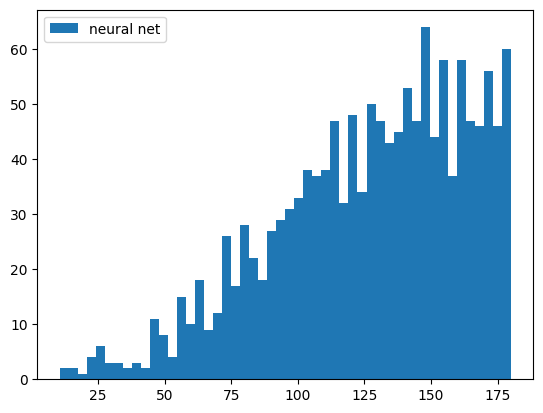

In [200]:
# mlp

#### alternate features

path = "/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random_10k/data"
png_files = glob.glob(os.path.join(path, '*.png'))
json_files = glob.glob(os.path.join(path, '*.json'))

def extract_png_number(filename):
    match = re.search(r'(\d+).png$', filename)
    if match:   return int(match.group(1))
    else:       return -1
    
def extract_json_number(filename):
    match = re.search(r'(\d+).json$', filename)
    if match:   return int(match.group(1))
    else:       return -1

png_files.sort(key=extract_png_number)
json_files.sort(key=extract_json_number)



n_keypoints = 30
descriptor_extractor = ORB(n_keypoints=n_keypoints)
def model_dimensions(img_np:np.ndarray):
    # assert img.min() == 0 and img.max() == 1

    # create object mask
    img_np_copy = img_np.copy()
    img_np_copy[np.where(img_np_copy<0.01)] = 0
    img_np_copy[np.where(img_np_copy>0.01)] = 1

    # determine object dimensions
    y,x,c = np.where(img_np_copy>0)
    ymin, ymax = np.min(y), np.max(y)
    xmin, xmax = np.min(x), np.max(x)
    height = ymax - ymin
    width = xmax - xmin

    # determine horizontal-wise pixel sums
    img_np_copy_bw = rgb2gray(img_np_copy.copy())
    horiz_sums = np.sum(img_np_copy_bw, axis=0)
    horiz_sums = horiz_sums/np.max(horiz_sums)
    horiz_sums = [i for i in horiz_sums]

    # determine vertical-wise pixel sums
    vert_sums = np.sum(img_np_copy_bw, axis=1)
    vert_sums = vert_sums/np.max(vert_sums)
    vert_sums = [i for i in vert_sums]

    # give it some ORB


    # --------------------

    ### ORB xvals
    try:
        descriptor_extractor.detect_and_extract(img_np_copy_bw)
    except:
        orb_descriptors = np.concatenate([np.zeros((n_keypoints, 256))], axis=0)
        orb_keypoints   = np.concatenate([np.zeros((n_keypoints, 2))],   axis=0)

    orb_descriptors = descriptor_extractor.descriptors.astype(np.float32)
    orb_keypoints = descriptor_extractor.keypoints.astype(np.float32)

    if len(orb_descriptors) < n_keypoints:
        orb_descriptors = np.concatenate([orb_descriptors, np.zeros((n_keypoints-len(orb_descriptors), 256))], axis=0)
        orb_keypoints   = np.concatenate([orb_keypoints, np.zeros((n_keypoints-len(orb_keypoints), 2))], axis=0)
    elif len(orb_descriptors) > n_keypoints:
        orb_descriptors = orb_descriptors[:n_keypoints]
    
    orb_descriptors = np.array(orb_descriptors, dtype=np.float32)
    orb_descriptors = orb_descriptors.reshape(orb_descriptors.shape[0], -1)

    orb_keypoints = np.array(orb_keypoints, dtype=np.float32)
    orb_keypoints = orb_keypoints.reshape(orb_keypoints.shape[0], -1)

    # --------------------

    return [height] + [width] + [ymin] + [ymax] + [xmin] + [xmax] + [height/width] + horiz_sums + vert_sums + orb_descriptors.flatten().tolist() + orb_keypoints.flatten().tolist()


# extract translation (xvals) from the data
import json
poses = []

for json_f in tqdm(json_files):
    with open(json_f) as f: poses.append(json.load(f)['pose'])

poses = np.array(poses, dtype=np.float32)
y_vals_dims = poses


# extract dimensions (yvals) from the data

dimensions = []
for png_f in tqdm(png_files):
    img = Image.open(png_f).convert('RGB')
    img_np = np.array(img)/255.0
    dimensions.append(model_dimensions(img_np))

dimensions = [np.array(dimensions[i]) for i in range(len(dimensions))]
dimensions = np.array(dimensions, dtype=np.float32)
x_vals_dims = dimensions


# do feature extraction on the input parameters


# mlp

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

scaler = StandardScaler()
scaler.fit(x_vals_dims[train_indices])
x_train = scaler.transform(x_vals_dims[train_indices])
x_test = scaler.transform(x_vals_dims[test_indices])

clf = MLPRegressor(random_state=1, max_iter=500).fit(x_train, y_vals_dims[train_indices])
y_pred = clf.predict(x_test)
name = 'neural net'

print(f'l2 score on test, {name}', sklearn.metrics.mean_squared_error(y_vals_dims[test_indices], y_pred, squared=False))
plt.hist(geodesic_rot_distance(y_vals_dims[test_indices], y_pred)*180/np.pi, bins=50, alpha=1, label=name)
plt.legend()
plt.show()


In [201]:

# mlp

#### alternate features

path = "/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random_10k/data"
png_files = glob.glob(os.path.join(path, '*.png'))
json_files = glob.glob(os.path.join(path, '*.json'))

def extract_png_number(filename):
    match = re.search(r'(\d+).png$', filename)
    if match:   return int(match.group(1))
    else:       return -1
    
def extract_json_number(filename):
    match = re.search(r'(\d+).json$', filename)
    if match:   return int(match.group(1))
    else:       return -1

png_files.sort(key=extract_png_number)
json_files.sort(key=extract_json_number)



n_keypoints = 30
descriptor_extractor = ORB(n_keypoints=n_keypoints)
def model_dimensions(img_np:np.ndarray):
    # assert img.min() == 0 and img.max() == 1

    # create object mask
    img_np_copy = img_np.copy()
    img_np_copy[np.where(img_np_copy<0.01)] = 0
    img_np_copy[np.where(img_np_copy>0.01)] = 1

    # determine object dimensions
    y,x,c = np.where(img_np_copy>0)
    ymin, ymax = np.min(y), np.max(y)
    xmin, xmax = np.min(x), np.max(x)
    height = ymax - ymin
    width = xmax - xmin

    # determine horizontal-wise pixel sums
    img_np_copy_bw = rgb2gray(img_np_copy.copy())
    horiz_sums = np.sum(img_np_copy_bw, axis=0)
    horiz_sums = horiz_sums/np.max(horiz_sums)
    horiz_sums = [i for i in horiz_sums]

    # determine vertical-wise pixel sums
    vert_sums = np.sum(img_np_copy_bw, axis=1)
    vert_sums = vert_sums/np.max(vert_sums)
    vert_sums = [i for i in vert_sums]

    # give it some ORB


    # --------------------

    ### ORB xvals
    try:
        descriptor_extractor.detect_and_extract(img_np_copy_bw)
    except:
        orb_descriptors = np.concatenate([np.zeros((n_keypoints, 256))], axis=0)
        orb_keypoints   = np.concatenate([np.zeros((n_keypoints, 2))],   axis=0)

    orb_descriptors = descriptor_extractor.descriptors.astype(np.float32)
    orb_keypoints = descriptor_extractor.keypoints.astype(np.float32)

    if len(orb_descriptors) < n_keypoints:
        orb_descriptors = np.concatenate([orb_descriptors, np.zeros((n_keypoints-len(orb_descriptors), 256))], axis=0)
        orb_keypoints   = np.concatenate([orb_keypoints, np.zeros((n_keypoints-len(orb_keypoints), 2))], axis=0)
    elif len(orb_descriptors) > n_keypoints:
        orb_descriptors = orb_descriptors[:n_keypoints]
    
    orb_descriptors = np.array(orb_descriptors, dtype=np.float32)
    orb_descriptors = orb_descriptors.reshape(orb_descriptors.shape[0], -1)

    orb_keypoints = np.array(orb_keypoints, dtype=np.float32)
    orb_keypoints = orb_keypoints.reshape(orb_keypoints.shape[0], -1)

    # --------------------

    return [height] + [width] + [ymin] + [ymax] + [xmin] + [xmax] + [height/width] + horiz_sums + vert_sums + orb_descriptors.flatten().tolist() + orb_keypoints.flatten().tolist()


# extract translation (xvals) from the data
import json
poses = []

for json_f in tqdm(json_files):
    with open(json_f) as f: poses.append(json.load(f)['pose'])

poses = np.array(poses, dtype=np.float32)
y_vals_dims = poses


# extract dimensions (yvals) from the data

dimensions = []
for png_f in tqdm(png_files):
    img = Image.open(png_f).convert('RGB')
    img_np = np.array(img)/255.0
    dimensions.append(model_dimensions(img_np))

dimensions = [np.array(dimensions[i]) for i in range(len(dimensions))]
dimensions = np.array(dimensions, dtype=np.float32)
x_vals_dims = dimensions


100%|██████████| 10000/10000 [12:33<00:00, 13.26it/s]


In [1]:


# do feature extraction on the input parameters

from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
x_vals_dims_small = sel.fit_transform(x_vals_dims)


# mlp

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

scaler = StandardScaler()
scaler.fit(x_vals_dims[train_indices])
x_train = scaler.transform(x_vals_dims[train_indices])
x_test = scaler.transform(x_vals_dims[test_indices])

clf = MLPRegressor(random_state=1, max_iter=500).fit(x_vals_dims_small[train_indices], y_vals_dims[train_indices])
x_test_small = sel.transform(x_test)
y_pred = clf.predict(x_test_small)
name = 'neural net with feature downselection'

print(f'l2 score on test, {name}', sklearn.metrics.mean_squared_error(y_vals_dims[test_indices], y_pred, squared=False))
plt.hist(geodesic_rot_distance(y_vals_dims[test_indices], y_pred)*180/np.pi, bins=50, alpha=1, label=name)
plt.legend()
plt.show()



NameError: name 'x_vals_dims' is not defined

l2 score on test, neural net with feature downselection 1.3677349


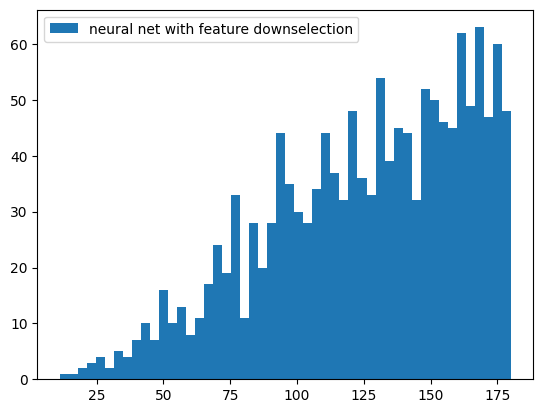

In [208]:


# do feature extraction on the input parameters

from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
x_vals_dims_small = sel.fit_transform(x_vals_dims)


# mlp

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

scaler = StandardScaler()
scaler.fit(x_vals_dims[train_indices])
x_train = scaler.transform(x_vals_dims[train_indices])
x_test = scaler.transform(x_vals_dims[test_indices])

clf = MLPRegressor([1000,100,100,100], random_state=1, max_iter=500).fit(x_vals_dims_small[train_indices], y_vals_dims[train_indices])
x_test_small = sel.transform(x_test)
y_pred = clf.predict(x_test_small)
name = 'neural net with feature downselection'

print(f'l2 score on test, {name}', sklearn.metrics.mean_squared_error(y_vals_dims[test_indices], y_pred, squared=False))
plt.hist(geodesic_rot_distance(y_vals_dims[test_indices], y_pred)*180/np.pi, bins=50, alpha=1, label=name)
plt.legend()
plt.show()

